In [9]:
import pandas as pd 
import numpy as np
import random
import operator
import math
import matplotlib.pyplot as plt 
from scipy.stats import multivariate_normal

### Date Preview

In [10]:
df_full = pd.read_csv("Iris.csv")
df_full = df_full.drop(['Id'], axis=1)
df_full.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [11]:
columns = list(df_full.columns)
features = columns[:len(columns)-1]
class_labels = list(df_full[columns[-1]])
df = df_full[features]

### Constants

In [12]:
k = 3 # Number of Clusters
MAX_ITER = 100 # Maximum number of iterations
n = len(df) # Number of data points
m = 1.7 # Fuzzy parameter # 1 -> ...

### Helper Functions

In [13]:
def getRandomMembership(): 
    randomList = [random.random() for i in range(k)]
    summation = sum(randomList)
    tempList = [x/summation for x in randomList]
        
    flag = tempList.index(max(tempList))
    for j in range(0,len(tempList)):
        if(j == flag):
            tempList[j] = 1
        else:
            tempList[j] = 0
            
    return tempList
            
def weightedAvg(weights):
    denominator = sum(weights)
    temp_num = []
    for i in range(n):
        point = list(df.iloc[i])
        prod = [weights[i] * val for val in point]
        temp_num.append(prod)
    numerator = map(sum, list(zip(*temp_num)))
    return [z/denominator for z in numerator]

In [14]:
def initMembershipMatrix():
    mMatrix = []
    for i in range(n):
        mMatrix.append(getRandomMembership())
        
    return mMatrix

def clustersCenters(mMatrix):
    clustersMembership = list(zip(*mMatrix))
    centers = []
    
    for clusterIndex in range(k):
        x = list(clustersMembership[clusterIndex])  
        weights = [p ** m for p in x]
        center = weightedAvg(weights)
        centers.append(center)
        
    return centers

def getClusters(mMatrix):
    labels = list()
    for i in range(n):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(mMatrix[i]))
        labels.append(idx)
    return labels

### Calculate Fuzzy Membership

![](1.jpg)
![](2.jpg)
![](3.jpg)

In [15]:
def updateMembershipValues(mMatrix, clustersCenters):
    p = float(2/(m-1))
    for i in range(n):
        x = list(df.iloc[i])
        distances = [np.linalg.norm(np.array(list(map(operator.sub, x, clustersCenters[clusterIndex])))) for clusterIndex in range(k)]
        for j in range(k):
            den = sum([math.pow(float(distances[j]/distances[c]), p) for c in range(k)])
            mMatrix[i][j] = float(1/den)       
    return mMatrix

### Accuracy

In [16]:
def accuracy(cluster_labels, class_labels):
    correct_pred = 0
    seto = max(set(labels[0:50]), key=labels[0:50].count)
    vers = max(set(labels[50:100]), key=labels[50:100].count)
    virg = max(set(labels[100:]), key=labels[100:].count)
    
    for i in range(len(df)):
        if cluster_labels[i] == seto and class_labels[i] == 'Iris-setosa':
            correct_pred = correct_pred + 1
        if cluster_labels[i] == vers and class_labels[i] == 'Iris-versicolor' and vers!=seto:
            correct_pred = correct_pred + 1
        if cluster_labels[i] == virg and class_labels[i] == 'Iris-virginica' and virg!=seto and virg!=vers:
            correct_pred = correct_pred + 1
            
    accuracy = (correct_pred/len(df))*100
    return accuracy

### Fuzzy CMeans Clustering

In [17]:
def fuzzyCMeans():
    mMatrix = initMembershipMatrix()
 
    curr = 0
    acc=[]
    
    while curr < MAX_ITER:
        centers = clustersCenters(mMatrix)
        mMatrix = updateMembershipValues(mMatrix, centers)
        clustersLabels = getClusters(mMatrix)
        
        acc.append(clustersLabels)

        curr += 1

    return clustersLabels, centers, acc

In [18]:
labels, centers, acc = fuzzyCMeans()
a = accuracy(labels, class_labels)
print(a)

88.66666666666667


### Ploting Results

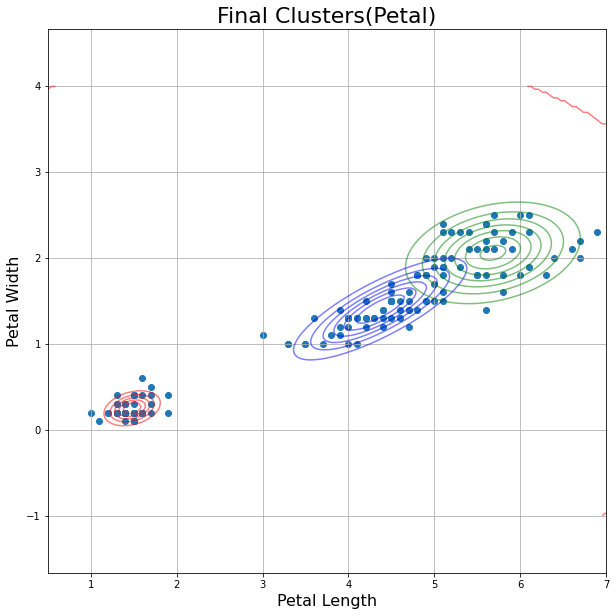

In [19]:
seto = max(set(labels[0:50]), key=labels[0:50].count)
vers = max(set(labels[50:100]), key=labels[50:100].count)
virg = max(set(labels[100:]), key=labels[100:].count)

s_mean_clus1 = np.array([centers[seto][0],centers[seto][1]])
s_mean_clus2 = np.array([centers[vers][0],centers[vers][1]])
s_mean_clus3 = np.array([centers[virg][0],centers[virg][1]])

values = np.array(labels)

searchval_seto = seto
searchval_vers = vers
searchval_virg = virg

ii_seto = np.where(values == searchval_seto)[0]
ii_vers = np.where(values == searchval_vers)[0]
ii_virg = np.where(values == searchval_virg)[0]
ind_seto = list(ii_seto)
ind_vers = list(ii_vers)
ind_virg = list(ii_virg)

sepal_df = df_full.iloc[:,0:2]
seto_df = sepal_df[sepal_df.index.isin(ind_seto)]
vers_df = sepal_df[sepal_df.index.isin(ind_vers)]
virg_df = sepal_df[sepal_df.index.isin(ind_virg)]
cov_seto = np.cov(np.transpose(np.array(seto_df)))
cov_vers = np.cov(np.transpose(np.array(vers_df)))
cov_virg = np.cov(np.transpose(np.array(virg_df)))
sepal_df = np.array(sepal_df)
x1 = np.linspace(4,8,150)  
x2 = np.linspace(1.5,4.5,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(s_mean_clus1, cov_seto)  
Z2 = multivariate_normal(s_mean_clus2, cov_vers)
Z3 = multivariate_normal(s_mean_clus3, cov_virg)

p_mean_clus1 = np.array([centers[seto][2],centers[seto][3]])
p_mean_clus2 = np.array([centers[vers][2],centers[vers][3]])
p_mean_clus3 = np.array([centers[virg][2],centers[virg][3]])
petal_df = df_full.iloc[:,2:4]
seto_df = petal_df[petal_df.index.isin(ind_seto)]
vers_df = petal_df[petal_df.index.isin(ind_vers)]
virg_df = petal_df[petal_df.index.isin(ind_virg)]
cov_seto = np.cov(np.transpose(np.array(seto_df)))
cov_vers = np.cov(np.transpose(np.array(vers_df)))
cov_virg = np.cov(np.transpose(np.array(virg_df)))
petal_df = np.array(petal_df)
x1 = np.linspace(0.5,7,150)  
x2 = np.linspace(-1,4,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(p_mean_clus1, cov_seto)  
Z2 = multivariate_normal(p_mean_clus2, cov_vers)
Z3 = multivariate_normal(p_mean_clus3, cov_virg)

pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
plt.scatter(petal_df[:,0], petal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                  # making both the axis equal
plt.xlabel('Petal Length', fontsize=16)                                                  # X-Axis
plt.ylabel('Petal Width', fontsize=16)                                                  # Y-Axis
plt.title('Final Clusters(Petal)', fontsize=22)                                            # Title of the plot
plt.grid()                                                                         # displaying gridlines
plt.show()